In [ ]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.2.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.7 MB)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, KFold,train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [ ]:
def get_scores(y_true, y_pred, classifier_name):
    result = pd.DataFrame()
    result["Classifier"] = [classifier_name]
    result["Accuracy"] = [accuracy_score(y_true, y_pred)]
    result["F1-Score (Macro)"] = [f1_score(y_true, y_pred, average="macro")]
    result["Precision  (Macro)"] = [precision_score(y_true, y_pred, average="macro")]
    result["Recall  (Macro)"] = [recall_score(y_true, y_pred, average="macro")]
    result["F1-Score (Micro)"] = [f1_score(y_true, y_pred, average="micro")]
    result["Precision  (Micro)"] = [precision_score(y_true, y_pred, average="micro")]
    result["Recall  (Micro)"] = [recall_score(y_true, y_pred, average="micro")]
    result["F1-Score (Weighted)"] = [f1_score(y_true, y_pred, average="weighted")]
    result["Precision  (Weighted)"] = [precision_score(y_true, y_pred, average="weighted")]
    result["Recall  (Weighted)"] = [recall_score(y_true, y_pred, average="weighted")]

    return result

# Load Data

In [ ]:
train = pd.read_csv("train.csv", index_col=None)
test = pd.read_csv("test.csv", index_col=None)

# Split Train/Val

In [ ]:
X_train=train.iloc[:,:-3]
y_train=train["Label"]
X_test=test.iloc[:,:-3]
y_test=test["Label"]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(5881, 561) (5881,) (1471, 561) (1471,) (2947, 561) (2947,)


# On Smoothing

In [ ]:
nb = GaussianNB()
nb.fit(X_train,y_train)
print(nb.classes_)
print(nb.class_count_) #in training
print(nb.class_prior_) #from training

[0 1 2 3 4 5]
[ 979.  873.  780. 1024. 1098. 1127.]
[0.16646829 0.14844414 0.13263051 0.17412005 0.18670294 0.19163408]


In [ ]:
#see class counts - no need for smoothing

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
CVAccuracy=[]
for i in cv.split(X_train):
  nb = GaussianNB(var_smoothing=0)
  nb.fit(X_train,y_train)
  CVAccuracy.append([nb.score(X_val, y_val)])
  df_unsmoothed = pd.DataFrame (CVAccuracy,columns=['Validation Accuracy'])

df_unsmoothed=df_unsmoothed.mean()
print(df_unsmoothed)

Validation Accuracy    0.731475
dtype: float64


In [ ]:
CVAccuracy=[]
for i in cv.split(X_train):
  nb = GaussianNB()
  nb.fit(X_train,y_train)
  CVAccuracy.append([nb.score(X_val, y_val)])
  df_smoothed = pd.DataFrame (CVAccuracy,columns=['Validation Accuracy'])

df_smoothed=df_smoothed.mean()
print(df_smoothed)

Validation Accuracy    0.730795
dtype: float64


# Prediction & Performance

In [ ]:
#this cell is re-run to train the final model on the entire train & validation set
X_train=train.iloc[:,:-3]
y_train=train["Label"]
X_test=test.iloc[:,:-3]
y_test=test["Label"]
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
nb = GaussianNB(var_smoothing=0) #only arguements it takes: prior & smoothing

nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)
get_scores(y_test,y_pred,"GNB")

,Classifier,Accuracy,F1-Score (Macro),Precision (Macro),Recall (Macro),F1-Score (Micro),Precision (Micro),Recall (Micro),F1-Score (Weighted),Precision (Weighted),Recall (Weighted)
0,GNB,0.770275,0.767235,0.792466,0.769066,0.770275,0.770275,0.770275,0.76877,0.794683,0.770275


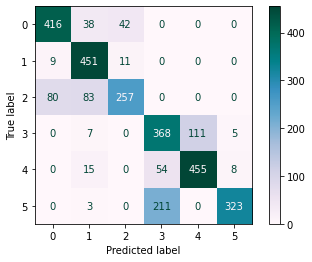

In [ ]:
conf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf).plot(cmap=plt.cm.PuBuGn)

# w/ Feature Selection

In [ ]:
selector = SelectFromModel(estimator=LogisticRegression(max_iter=10000)).fit(X_train, y_train)

In [ ]:
selector.threshold_

0.9650203508155041

In [ ]:
X_new_train=selector.transform(X_train)
X_new_test=selector.transform(X_test)
X_new_val=selector.transform(X_val)
X_new_train.shape

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(7352, 190)

In [ ]:
nb = GaussianNB(var_smoothing=0)
nb.fit(X_new_train,y_train)
y_pred = nb.predict(X_new_test)
get_scores(y_test,y_pred,"GNB")

,Classifier,Accuracy,F1-Score (Macro),Precision (Macro),Recall (Macro),F1-Score (Micro),Precision (Micro),Recall (Micro),F1-Score (Weighted),Precision (Weighted),Recall (Weighted)
0,GNB,0.872413,0.866081,0.888347,0.867408,0.872413,0.872413,0.872413,0.867909,0.887103,0.872413


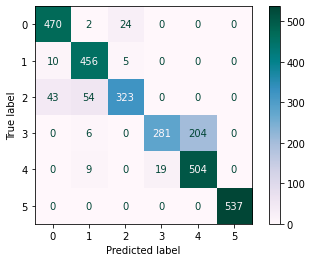

In [ ]:
conf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf).plot(cmap=plt.cm.PuBuGn)